In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
pd.options.display.max_columns = 99

# Imports for NLP Analysis of Columns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans



In [2]:
Data_Files = ['Data/One_SuperHeroes.csv','Data/All_SuperHeroes.csv']

csv_file = Data_Files[0]
sectionID = 4
num_groups = 3
Homogenous = True

In [3]:
def calc_group_sizes(num_students, num_groups):
    '''
    Parameters
    -----------
    num_students : int
        Number of students in the class
    num_groups : int
        Number of groups to break students into
    
    Returns
    ---------
    group_size : List of ideal group sizes
    '''
    group_sizes = []

    class_size = num_students
    group_num_count = num_groups
    group_num = num_groups

    for i in range(group_num_count):
        temp = class_size // group_num
        class_size -= temp
        group_num -= 1
        group_sizes.append(temp)

    return group_sizes

In [4]:
def clean_file(dataframe,sectionID):
    '''
    Clean CSV file
    --------------------

    Parameters
    -----------
    .csv file :
    sectionID : Class/Period Number to Group

    Returns
    ---------
    Pandas DataFrame (Cleaned)
    '''
    sectionID = str(sectionID)
    
    df = dataframe
    df.set_index(keys=df['name'],inplace=True)

    df['section'] = df.section.str.extract('(\d+)')
    df = df[df['section']==sectionID]

    df = df.select_dtypes(exclude=['object','bool'])

    df.drop(columns=['id','section_sis_id','attempt','section_id'],inplace=True)

    return df

In [5]:
def normalize_df(df):
    '''
    Normalize DataFrame Values from 0-1
    
    Parameters
    ----------
    df : DataFrame to Normalize
    
    Returns
    -------
    Normalized DataFrame
    '''
    return df.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) if np.min(x) != np.max(x) else x)
    

In [6]:
def add_clusters(df, num_clusters=6):
    '''
    Add Clusters
    
    Parameters
    ----------
    df : DataFrame to Clusterize
    num_clusters : Number of Clusters to Create
    
    Returns
    -------
    Clusterized DataFrame
    '''
    df = df.copy()
    kmeans = KMeans(num_clusters)
    kmeans.fit(df)
    cluster = kmeans.predict(df)
    df['Cluster'] = cluster
    
    return df

In [7]:
# def make_barplot(df, x_val = "Cluster",y_val="score"):
#     plot = sns.barplot(x = x_val, y = y_val, data = df);
#     plot.axes.set_title("Mean Score of Students per Cluster",fontsize=20,weight="bold")
#     plot.axes.set_xlabel("Cluster",fontsize=20,weight="bold")
#     plot.axes.set_ylabel("Mean Score",fontsize=20,weight="bold")
#     plot.tick_params(labelsize=15)
#     # plot.figsize=(12,12)

In [8]:
# def make_countplot(df, x_val = 'Cluster'):
#     plot = sns.countplot(x = x_val, data = df);
#     plot.axes.set_title("Frequency of Students per Cluster",fontsize=20,weight="bold")
#     plot.axes.set_xlabel("Cluster",fontsize=20,weight="bold")
#     plot.axes.set_ylabel("Frequency",fontsize=20,weight="bold")
#     plot.tick_params(labelsize=15)

In [9]:
def return_cluster_list(df,num_clusters=6):
    '''
    Return a List of Clustered Students
    
    Parameters
    ----------
    df : Pandas DataFrame
    num_clusters : Number of clusters to create
    
    Returns
    -------
    
    '''
    cluster_list = []

    for i in range(num_clusters):
        cluster_list.append(list(df[df['Cluster']==i].index))

    return cluster_list

In [10]:
def generate_optimized_groups(student_df, num_iter = 100, num_groups = 6, Homogeneous = 0, criteria = 'score'):
    '''

    Parameters
    ----------
    student_df : DataFrame with student names as index and score column
    num_iter : int
        Number of Iterations to run loss function
    num_groups : int
        Number of groups to divide students into
    Homogeneous : bool
        If True, create Homogeneous (similar) groups.
        If False, create Heterogeneous (different) groups

    Returns
    -------
    Optimal Groups
    '''
    index_list = list(student_df.index)

    if Homogeneous == 0:
        ideal_loss = 9999
    elif Homogeneous == 1:
        ideal_loss = 0
    num_students = len(student_df)

    size_list = calc_group_sizes(num_students,num_groups)

    for i in range(num_iter):
        randomized_index_list = np.random.choice(index_list, size = len(index_list),replace=False)
        group_set = set({})
        index_track = 0
        total_loss = 0

        for num in size_list:
            j = frozenset(randomized_index_list[0 + index_track:index_track+num])
            group_set.add(j)
            index_track += num

        for group in group_set:
            unfrozen = set(group)
            group_loss = 0
            avg_score = np.mean(student_df.loc[unfrozen][criteria])

            for s in range(len(group)):
                group_loss += (student_df.loc[unfrozen][criteria][s] - avg_score) ** 2

            total_loss += group_loss

        if Homogeneous == 0 and total_loss < ideal_loss:
            ideal_loss = total_loss
            best_group = group_set
            print("New Best Homogeneous Group Loss:", ideal_loss)

        elif Homogeneous == 1 and total_loss > ideal_loss:
            ideal_loss = total_loss
            best_group = group_set
            print("New Best Heterogeneous Group Loss:", ideal_loss)

    print("\n")
    print("Final Best Group Loss:", ideal_loss)
    print("Final Best Grouping:\n")


    for i,g in enumerate(best_group):
        print("Group",i+1)
        print(student_df.loc[set(g)][criteria],"\n")

    return best_group

# EDA!

## Data Cleaning

In [11]:
df = pd.read_csv('Data/One_SuperHeroes.csv',encoding = 'latin-1')

In [12]:
zf = clean_file(df, 4)

In [13]:
xf = clean_file(df, 6)

In [14]:
df = pd.concat([zf, xf])

In [15]:
df = normalize_df(df)

In [16]:
df.head()

,1,1.1,1.2,8,5,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.10,1.11,1.12,4,1.13,1.14,1.15,1.16,4.1,1.17,1.18,n correct,n incorrect,score
name,,,,,,,,,,,,,,,,,,,,,,,,,,
Black Widow,1.0,0.0,0.0,0.000000,0.6,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1,0.0,1.0,0.000000
Storm,1.0,1.0,1.0,1.000000,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1,0.7,0.3,0.857143
Ant-Man,1.0,1.0,1.0,0.666667,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5,1.0,1,0.9,0.1,0.761905
Hawkman,1.0,1.0,0.0,0.333333,0.6,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1,0.3,0.7,0.238095
Beast,1.0,1.0,1.0,0.666667,0.6,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1,0.5,0.5,0.571429


## DataFrame Overview

In [17]:
df.describe()

,1,1.1,1.2,8,5,1.3,1.4,1.5,1.6,1.7,1.8,1.9,1.10,1.11,1.12,4,1.13,1.14,1.15,1.16,4.1,1.17,1.18,n correct,n incorrect,score
count,40.00000,40.000000,40.000000,40.000000,40.000,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.0,40.000000,40.000000,40.000000
mean,0.85000,0.975000,0.750000,0.750000,0.770,0.750000,0.575000,0.800000,0.725000,0.85000,0.950000,0.750000,0.925000,0.700000,0.950000,0.783333,0.600000,0.900000,0.825000,0.700000,0.831250,0.825000,1.0,0.630000,0.370000,0.639286
std,0.36162,0.158114,0.438529,0.322473,0.242,0.438529,0.500641,0.405096,0.452203,0.36162,0.220721,0.438529,0.266747,0.464095,0.220721,0.366317,0.496139,0.303822,0.384808,0.464095,0.306905,0.384808,0.0,0.245158,0.245158,0.246113
min,0.00000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,1.00000,1.000000,0.750000,0.500000,0.600,0.750000,0.000000,1.000000,0.000000,1.00000,1.000000,0.750000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000,1.000000,0.000000,0.687500,1.000000,1.0,0.475000,0.200000,0.511905
50%,1.00000,1.000000,1.000000,1.000000,0.600,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.650000,0.350000,0.666667
75%,1.00000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,0.800000,0.525000,0.821429
max,1.00000,1.000000,1.000000,1.000000,1.000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


In [18]:
df.shape

(40, 26)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40 entries, Black Widow to Star-Lord
Data columns (total 26 columns):
1              40 non-null float64
1.1            40 non-null float64
1.2            40 non-null float64
8              40 non-null float64
5              40 non-null float64
1.3            40 non-null float64
1.4            40 non-null float64
1.5            40 non-null float64
1.6            40 non-null float64
1.7            40 non-null float64
1.8            40 non-null float64
1.9            40 non-null float64
1.10           40 non-null float64
1.11           40 non-null float64
1.12           40 non-null float64
4              40 non-null float64
1.13           40 non-null float64
1.14           40 non-null float64
1.15           40 non-null float64
1.16           40 non-null float64
4.1            40 non-null float64
1.17           40 non-null float64
1.18           40 non-null int64
n correct      40 non-null float64
n incorrect    40 non-null float64
score       

## Graphs

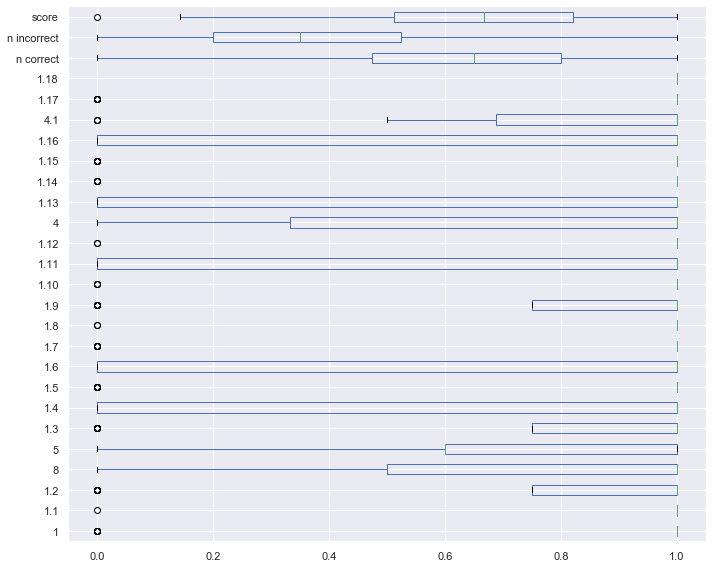

In [20]:
df.boxplot(column=None, by=None, ax=None, fontsize=None, 
                  rot=0, grid=True, figsize=(10,8), layout=None, return_type=None, vert = False);

plt.tight_layout()

# NLP Clustering of Questions

In [21]:
def create_questions_list(df, cols=['id','sis_id','section_id','section_sis_id','submitted','attempt','score','name','section']):
    '''
    Takes DataFrame and creates a NumPy array.
    
    Parameters
    ----------
    df : Pandas DataFrame
    cols : list of columns to drop from DataFrame
    
    Returns
    -------
    List of Questions
    '''
    df.drop(columns=cols,inplace=True)
    df = df.select_dtypes(exclude=['float'])
    df = df.select_dtypes(exclude=['int'])
    column_name_list = np.array(list(df.columns))
    quest_list = []
    for quest in column_name_list:
        quest_list.append(quest[6:])
    return np.array(quest_list)

In [22]:
def cluster_question_topics(quest_list,num_clust = 3,num_top_words = 3,stop_words = ["q"], max_features = 50):
    '''
    Create clusters of questions based on word usage
    
    Parameters
    ----------
    quest_list : list of questions
    num_clust : number of question clusters to create
    num_top_words : number of words to display in result
    stop_words : list of words to remove from clustering
    max_features : number of words to include in clustering (top X by frequency)
    
    Returns
    -------
    String of results
    Labels of Clustered Questions
    '''
    
#     my_stop_words = text.ENGLISH_STOP_WORDS.union(["ae","word","exam","alphabetical","options","order",
#                                         "things","used",'________','called','likely','provides','provide',
#                                         '_____','10','correct','match','12','14','32777','isa','thing','11',
#                                         '13','sentence','definition','suffix','suffixes','prefix','prefixes',
#                                         'uses','terms','means','following','function','specialist',
#                                         'position','correctly','directional','body','anatomical','plane',
#                                         'means_________'])

    my_stop_words = text.ENGLISH_STOP_WORDS.union(stop_words)
    
    vectorizer = TfidfVectorizer(strip_accents='ascii',stop_words=my_stop_words,max_features=max_features)
    X = vectorizer.fit_transform(quest_list)
    means = KMeans(num_clust,).fit(X)
                                 
    #print("Top terms per cluster:")
    order_centroids = means.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    
    topics_dict = dict()

    for i in range(num_clust):
        
        topics_dict[i] = []
        
        
#         print("\nCluster {}:".format(str(i+1)))
#         string_results += ("\nCluster {}:".format(str(i+1)))
        for ind in order_centroids[i, :num_top_words]:
#             print(' %s' % terms[ind])
#             string_results += (' %s' % terms[ind])
            topics_dict[i].append(terms[ind])
#     print(means.labels_)

    return (topics_dict, np.array(means.labels_))


In [23]:
def labels_to_dict(labels):
    '''
    Takes clustered question labels and returns dictionary with cluster as key and question #'s as values
    
    Parameters
    ----------
    labels : list of question labels
    
    Returns
    -------
    Dictionary with question cluster as key and question #'s as values
    '''
    quest_dict = dict()

    for i, val in enumerate(labels):
        if val in quest_dict:
            quest_dict[val].append(i+1)
        else:
            quest_dict[val] = ([i+1])
    
    return quest_dict

In [24]:
df = pd.read_csv('Data/One_SuperHeroes.csv',encoding = 'latin-1')

In [25]:
q_list = create_questions_list(df)

In [26]:
q_list

array([' The structural and functional unit of all living things is the ________.',
       ' Groups of cells that are similar in both structure and function are known as ________.',
       ' A(n) _____________________ is a structure made up of several tissues grouped together to perform a single function.',
       ' \rWord Bank:\r\rtissue\rsquamousåÊ\rsimpleåÊ\rstratifiedåÊ\rcuboidal\rglandular\rtransitional\rpseudostratified\r\råÊ\r\rOne single layer of cells is called [simple]\rTissues specialized in secreting are called [glandular]\rCube shaped cells are [cuboidal]\rMany layers of cells is called [stratified]\rA group of cells with the same specialized purpose is a [tissue]\rA group of cells that appear to be in layers is called [pseudostratified]\rFlat cells that cover many body parts and glands are called [squamous]\rTissues whose cells change size and shape are [transitional]\r\råÊ\r',
       ' ', ' \rWhat type of epithelial tissue is this?\r\r',
       ' \råÊ\rThe tissue shown i

In [27]:
string_dict, labels = cluster_question_topics(q_list, num_clust = 3,num_top_words = 5,
                                             stop_words = [""], max_features = 50 ) ;

In [28]:
string_dict

{0: ['tissue', 'body', 'called', 'connective', 'provides'],
 1: ['________', 'walls', 'shown', 'things', 'unit'],
 2: ['type', 'tissue', 'epithelial', 'nervous', 'tract']}

In [29]:
labels

array([1, 1, 0, 0, 0, 2, 1, 2, 2, 0, 2, 0, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0,
       0], dtype=int32)

In [30]:
d_money = labels_to_dict(labels)

In [31]:
d_money

{1: [1, 2, 7, 13, 14, 15],
 0: [3, 4, 5, 10, 12, 16, 18, 19, 20, 21, 22, 23],
 2: [6, 8, 9, 11, 17]}

## Create Student Strength/Growth Groups based on Question Cluster

In [32]:
def make_student_growth_and_strength_df(df,sectionID,cluster_labels):
    '''
    Create a DataFrame that includes students strengths and growth areas for question clusters

    Return a List of Clustered Students
    
    Parameters
    ----------
    df : Pandas DataFrame
    sectionID : Section Number for Students
    
    Returns
    -------
    Pandas DataFrame with strengths and growth areas for question clusters
    
    '''
    clean_df = clean_file(df,sectionID)
    quest_num_df = clean_df.iloc[:,0:-3]
    quest_num_df.columns = cluster_labels
    quest_num_df_grouped = quest_num_df.groupby(quest_num_df.columns, axis=1).sum()
    grouped_quest_normed_df = normalize_df(quest_num_df_grouped)
    
    x = grouped_quest_normed_df.copy().ix[0]
    x.index[x.argmin()]
    min_list, max_list = [], []

    for i in range (len(grouped_quest_normed_df)):
        x = grouped_quest_normed_df.ix[i]
        
        min_list.append(x.index[x.argmin()])
        max_list.append(x.index[x.argmax()])
        
        
    grouped_quest_normed_df['Strength Area'] = max_list
    grouped_quest_normed_df['Growth Area'] = min_list
    
    return grouped_quest_normed_df
    

In [33]:
def generate_growth_groups(df,num_groups):
    '''

    Parameters
    ----------
    student_df : DataFrame with student names as index and Strength/Growth Areas included

    Returns
    -------
    Growth Area Groups
    '''
    index_list = list(df.index)

    cluster_focus = []
    
    for i in range(num_groups):
        
        cluster_focus.append(list(df[df['Growth Area']==i].index))
    
    print("Grouping by Growth Areas:\n")

    for i,g in enumerate(cluster_focus):
        print("Group",i+1)
        print(str(g)+"\n")

    return cluster_focus

In [34]:
def generate_strength_groups(df,num_groups):
    '''

    Parameters
    ----------
    student_df : DataFrame with student names as index and Strength/Growth Areas included

    Returns
    -------
    Growth Area Groups
    '''
    index_list = list(df.index)

    cluster_focus = []
    
    for i in range(num_groups):
        
        cluster_focus.append(list(df[df['Strength Area']==i].index))
    
    print("Grouping by Strength Areas:\n")

    for i,g in enumerate(cluster_focus):
        print("Group",i+1)
        print(str(g)+"\n")

    return cluster_focus

In [35]:
df = pd.read_csv('Data/One_SuperHeroes.csv',encoding = 'latin-1')

In [36]:
xf = make_student_growth_and_strength_df(df,4,cluster_labels=labels) ;

/Users/jackvessa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/Users/jackvessa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
/Users/jackvessa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-i

In [37]:
xf.head()

,0,1,2,Strength Area,Growth Area
name,,,,,
Black Widow,0.0000,0.00,0.75,2,0
Storm,0.9375,0.75,0.75,0,1
Ant-Man,0.7500,0.75,1.00,2,0
Hawkman,0.3125,0.50,0.25,1,2
Beast,0.6875,0.50,0.50,0,1


In [38]:
generate_growth_groups(xf,3) ;

Grouping by Growth Areas:

Group 1
['Black Widow', 'Ant-Man', 'Magneto', 'Flash', 'Colossus', 'Hulk', 'Penguin', 'Joker', 'Spiderman']

Group 2
['Storm', 'Beast', 'Thor', 'Jean Grey']

Group 3
['Hawkman', 'Hellboy', 'Loki', 'The Wasp', 'Clint Barton']



In [39]:
generate_strength_groups(xf,3) ;

Grouping by Strength Areas:

Group 1
['Storm', 'Beast', 'Colossus', 'The Wasp', 'Spiderman']

Group 2
['Hawkman', 'Hellboy', 'Loki', 'Magneto', 'Flash', 'Penguin', 'Clint Barton', 'Joker']

Group 3
['Black Widow', 'Ant-Man', 'Thor', 'Hulk', 'Jean Grey']



## Cleaning Data Scratch Work

In [40]:
df.drop(df.index[0], inplace=True)

In [41]:
df.set_index(keys=df['Student'],inplace=True)

KeyError: 'Student'

In [ ]:
df.drop(columns=['Student','ID','SIS User ID','SIS Login ID'],inplace=True)

In [ ]:
df.drop(index = ['Test Student'], inplace=True)

In [ ]:
# Parse out Section Number
df['Section'] = int(df.Section.str.extract('(\d+)'))

In [ ]:
df = df.loc[:, df.isnull().mean() < .4]

In [ ]:
df.fillna(0,inplace=True)

In [ ]:
df.drop(columns=['Assignments Current Points','Assignments Final Points','Assignments Unposted Current Score','Assignments Final Score'],inplace=True)
df.drop(columns=['Assignments Unposted Final Score','Imported Assignments Current Points','Imported Assignments Final Points','Imported Assignments Current Score'],inplace=True)
df.drop(columns=['Imported Assignments Unposted Current Score','Unposted Final Score','Final Score','Unposted Current Score'],inplace=True)
df.drop(columns=['Assignments Current Score','Imported Assignments Final Score','Imported Assignments Unposted Final Score','Current Points','Final Points'],inplace=True)

In [ ]:
# def clean_file_all_assignments(dataframe,sectionID):
#     '''
#     Clean CSV file
#     --------------------

#     Parameters
#     -----------
#     .csv file :
#     sectionID : Class/Period Number to Group

#     Returns
#     ---------
#     Pandas DataFrame (Cleaned)
#     '''
#     sectionID = str(sectionID)
#     df = dataframe
#     df.drop(df.index[0], inplace=True)

#     df.set_index(keys=df['Student'],inplace=True)
#     df.drop(index = ['Test Student'], inplace=True)

#     # Parse out Section Number
#     df['Section'] = df.Section.str.extract('(\d+)')
#     df = df[df['Section']==sectionID]

#     df.drop(columns=['Student','ID','SIS User ID','SIS Login ID'],inplace=True)
#     df.drop(columns=['Assignments Current Points','Assignments Final Points','Assignments Unposted Current Score','Assignments Final Score'],inplace=True)
#     df.drop(columns=['Assignments Unposted Final Score','Imported Assignments Current Points','Imported Assignments Final Points','Imported Assignments Current Score'],inplace=True)
#     df.drop(columns=['Imported Assignments Unposted Current Score','Unposted Final Score','Final Score','Unposted Current Score'],inplace=True)
#     df.drop(columns=['Assignments Current Score','Imported Assignments Final Score','Imported Assignments Unposted Final Score','Current Points','Final Points'],inplace=True)

#     df = df.loc[:, df.isnull().mean() < .4]
#     df.fillna(0,inplace=True)
#     class_df = df.copy()
#     class_df['Current Score'] = df['Current Score'].apply(lambda x: float(x))

#     return class_df

In [ ]:
df = clean_file_all_assignments(csv_file,'2')
df = normalize_df(df)
generate_optimized_groups(df, criteria = 'Current Score')

In [ ]:
df.head()

In [ ]:
student_df2 = clean_file(csv_file)

In [ ]:
student_df = clean_file(csv_file,sectionID)

In [ ]:
student_df = normalize_df(student_df)

In [ ]:
student_df = add_clusters(student_df,3)

In [ ]:
def return_cluster_list(df,num_groups=6):
    cluster_list = []
    
    for i in range(num_groups):
        cluster_list.append(list(student_df[student_df['Cluster']==i].index))
        
    return cluster_list
        

In [ ]:
return_cluster_list(student_df,3)

In [ ]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

In [ ]:
index_list = list(student_df.index)



for i in range(10):
    randomized_index_list = np.random.choice(index_list, size = len(index_list),replace=False)
    group_set = set({})
    index_track = 0
    for num in size_list:
        
        j = frozenset(randomized_index_list[0 + index_track:index_track+num])
        group_set.add(j)
        index_track += num
    
    print('\n   Group Trial:', i)
    for group in group_set:
        unfrozen = set(group)
        print(unfrozen)
#         print(unfrozen)
    
    


    

In [ ]:
j = set(randomized_index_list[0:3])

In [ ]:
j

In [ ]:
index_list

In [ ]:
randomized_index_list

In [ ]:
# from itertools import combinations

# size_of_groups = 3

# for index in list(combinations(df.index,size_of_groups)):

#     print(df.loc[index,:]['score'])
#     loss = 0
    
#     avg_score = np.mean(df.loc[index,:]['score'])
#     for i in range(size_of_groups):
#         loss += (df.loc[index,:]['score'][i] - avg_score) ** 2
#     print("Loss:",loss)
    
#     print('\n')
    
    

In [ ]:
team_list = []

df = student_df.copy()
for i in range(8):
    x = z.sample(n = 3) 

    team_list.append(x.index)


In [ ]:
x = pd.read_csv(csv_file, encoding = 'latin-1')
num_clusters = 3
data_frame, section_id = x, 4

In [ ]:

student_df = clean_file(data_frame,section_id)
student_df = normalize_df(student_df)
student_df = add_clusters(student_df, num_clusters = num_clusters)
result = return_cluster_list(student_df, num_clusters)
groups_string = ""
for i,val in enumerate(result):
    
    groups_string += "<br/>Cluster " + str(i+1) + ":<br/>"
    groups_string += str(list(val)) + "<br/>"
    groups_string += ("Score Range: " +
        str(round((np.max(student_df.loc[val]['score'])-np.min(student_df.loc[val]['score']))*100,3)) +"%")

In [ ]:
groups_string

In [ ]:
# student_df.loc[['Black Widow','Storm']]

# Webscraping Anatomy Test (270 Q's)

In [ ]:
# import requests 
# URL = "https://www.proprofs.com/quiz-school/story.php?title=anatomy-physiology-final-exam-prep-test"
# r = requests.get(URL) 
# print(r.content) 

In [ ]:
# from bs4 import BeautifulSoup 

In [ ]:
# soup = BeautifulSoup(r.content, 'html5lib') 
# print(soup.prettify()) 

In [ ]:
# questions=[]  # a list to store quotes

In [ ]:
# table = soup.find('div', attrs = {'class':'question-text'})

In [ ]:
# for row in soup.findAll('div', attrs = {'class':'question-text'}): 
#     questions.append(row.string)

In [ ]:
# num_clust = 5
# num_top_words = 3

# my_stop_words = text.ENGLISH_STOP_WORDS.union(["ae","following"])

# vectorizer = TfidfVectorizer(strip_accents='ascii',stop_words=my_stop_words,max_features=10000)
# X = vectorizer.fit_transform(questions)
# means = KMeans(num_clust).fit(X)

# print("Top terms per cluster:")
# order_centroids = means.cluster_centers_.argsort()[:, ::-1]
# terms = vectorizer.get_feature_names()
# for i in range(num_clust):
#     print("\nCluster {}:".format(str(i+1)))
#     for ind in order_centroids[i, :num_top_words]:
#         print(' %s' % terms[ind])
# x= means.labels_

In [ ]:
#y = pd.DataFrame(x)

In [ ]:
#y.groupby(by=0).size()

In [ ]:
#quest_list[3]

In [ ]:
# vectorizer = TfidfVectorizer(strip_accents='ascii',stop_words=my_stop_words,max_features=80)
# ZZ = vectorizer.transform(quest_list[2:4])

In [ ]:
#vectorizer.get_feature_names()

In [ ]:
#means.predict(ZZ)